In [9]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from scipy import stats

%matplotlib inline

$
Age \sim \mathcal{N}(50, 15) \\
City \sim Bernoulli(0.4)
$

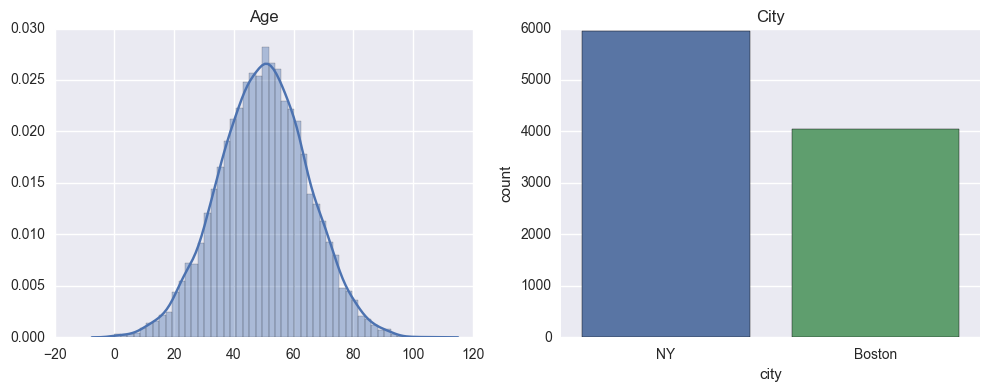

In [16]:
N = 10000
mu = 50
sigma = 15
p = 0.4
T_support = ['morning', 'night']

age = [max(0, a) for a in stats.norm(mu, sigma).rvs(N)]
city_binary = stats.bernoulli(p).rvs(N)
city = ['Boston' if x == 1 else 'NY' for x in city_binary]

demo_data = pd.DataFrame(zip(age, city), columns=['age', 'city'])

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title("Age")
ax2 = fig.add_subplot(122)
ax2.set_title("City")

sns.distplot(age, hist=True, ax=ax1)
sns.countplot(x='city', data=demo_data, ax=ax2)

fig.tight_layout()

We'll assume that the time of day in which an individual visits our website is dependent on age and city. Let's group time of day into 2 possible values: morning, night. We'll call this variable T.
Then we define the conditional random variable for the time of the day someone logs in depending on age/city. We assume that 

$X: T | A, C$

In [17]:
sig = lambda t: 1 / (1 + np.exp(-t))
norm = lambda x, mu, sigma: (x - mu) / sigma

ny_p = lambda x: sig(norm(x, mu, sigma))
bos_p = lambda x: sig(norm(x, mu-5, sigma))

demo_data.loc[:, 'p'] = demo_data.apply(lambda row: ny_p(row['age']) if row['city'] == 'NY' else bos_p(row['age']), axis=1)
demo_data.head(5)

,age,city,p
0,8.570094,NY,0.059413
1,38.288529,NY,0.314155
2,53.591950,NY,0.559581
3,63.664355,NY,0.713196
4,61.159460,NY,0.677862


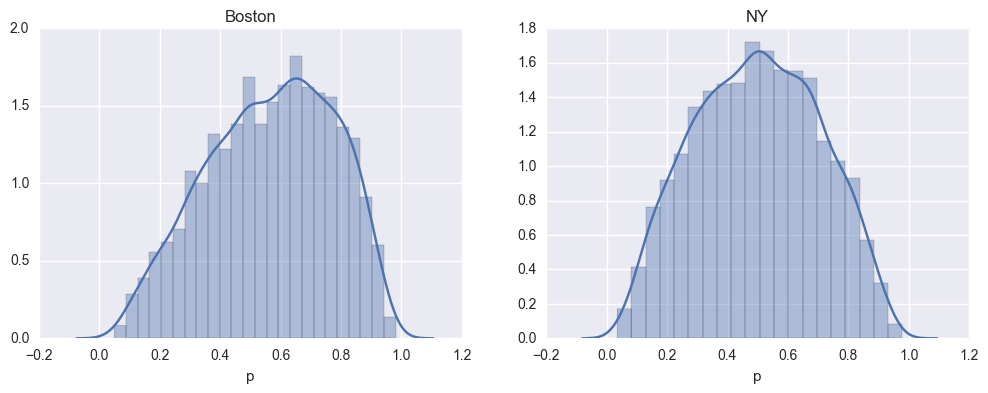

In [18]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('Boston')
ax2.set_title('NY')
sns.distplot(demo_data[demo_data.city == 'Boston'].p, ax=ax1)
sns.distplot(demo_data[demo_data.city == 'NY'].p, bins=20, ax=ax2)

Let's assume that Y is the number of visitors that use the new feature, and the older the visitor, the more likely (s)he is to use it. Also, let's assume that people from Boston are more prone to use it than those from NY. 

In [19]:
ny_py = lambda x: sig(norm(x, mu+15, sigma))
bos_py = lambda x: sig(norm(x, mu+5, sigma))

demo_data.loc[:, 'py'] = demo_data.apply(lambda row: ny_py(row['age']) if row['city'] == 'NY' else bos_py(row['age']), axis=1)
demo_data.head(5)

,age,city,p,py
0,8.570094,NY,0.059413,0.022710
1,38.288529,NY,0.314155,0.144209
2,53.591950,NY,0.559581,0.318530
3,63.664355,NY,0.713196,0.477754
4,61.159460,NY,0.677862,0.436338


### Simulate one day

In [20]:
demo_data.loc[:, 'tod'] = demo_data.p.map(lambda p: T_support[stats.bernoulli(1-p).rvs()])
demo_data.loc[:, 'y'] = demo_data.py.map(lambda p: stats.bernoulli(p).rvs())
demo_data.head(5)

,age,city,p,py,tod,y
0,8.570094,NY,0.059413,0.022710,night,0
1,38.288529,NY,0.314155,0.144209,night,0
2,53.591950,NY,0.559581,0.318530,morning,0
3,63.664355,NY,0.713196,0.477754,morning,0
4,61.159460,NY,0.677862,0.436338,morning,0


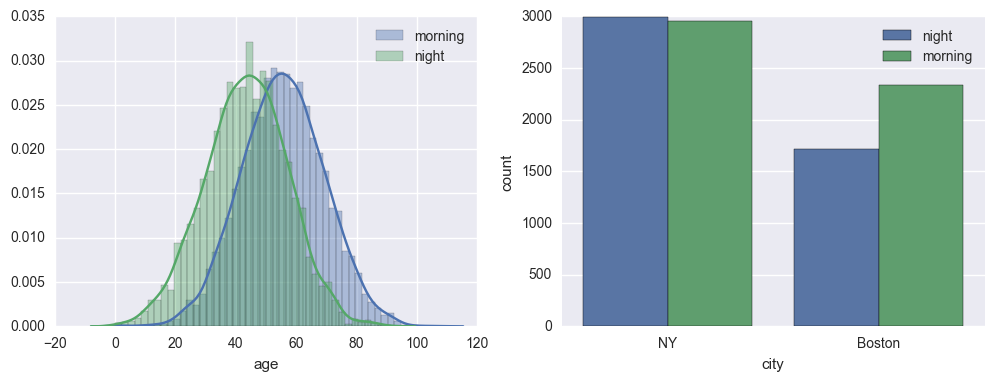

In [21]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
sns.distplot(demo_data[demo_data.tod == T_support[0]].age, hist=True, label=T_support[0], ax=ax1)
sns.distplot(demo_data[demo_data.tod == T_support[1]].age, hist=True, label=T_support[1], ax=ax1)
plt.legend(loc='best')

ax2 = fig.add_subplot(122)
sns.countplot(x="city", hue='tod', data=demo_data)
    
plt.legend(loc='best')

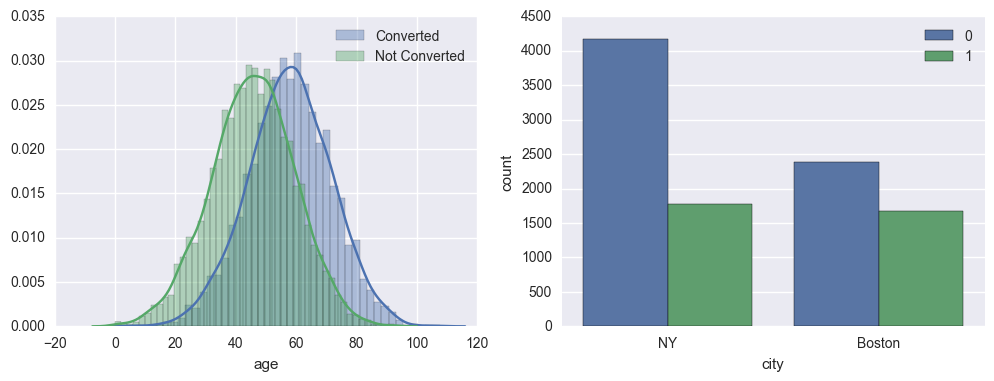

In [22]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
sns.distplot(demo_data[demo_data.y == 1].age, hist=True, label='Converted', ax=ax1)
sns.distplot(demo_data[demo_data.y == 0].age, hist=True, label='Not Converted', ax=ax1)
plt.legend(loc='best')

ax2 = fig.add_subplot(122)
sns.countplot(x="city", hue='y', data=demo_data)
    
plt.legend(loc='best')

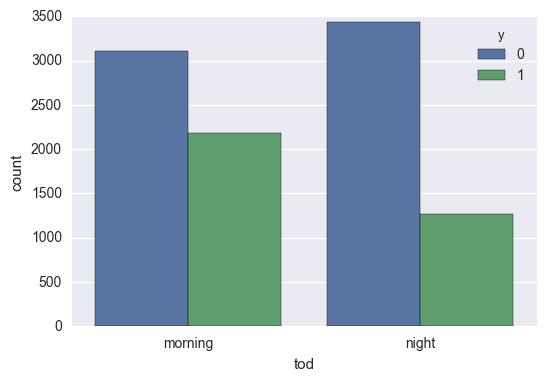

In [23]:
sns.countplot(x="tod", hue='y', data=demo_data, order=[T_support[0], T_support[1]])

### From experiment

In [24]:
def print_comparison(base, other):
    baseline_success = 1. * base.sum() / len(base)
    other_success = 1. * other.sum() / len(other)
    pval = stats.binom_test(x=other.sum(), n=len(other), alternative='greater', p=baseline_success)
    print 'Baseline: {}\nOther: {}\nP-val: {}'.format(baseline_success, other_success, pval)
    
def compare_covariates_two(base, other, base_name, other_name, ylim=6500):
    fig = plt.figure(figsize=(12, 12))

    ax1 = fig.add_subplot(221)
    sns.distplot(base.age, hist=True, label=base_name, ax=ax1)
    sns.distplot(other.age, hist=True, label=other_name, ax=ax1)
    plt.legend(loc='best')

    ax2 = fig.add_subplot(223)
    base_boston_ratio = 1. * base[base.city == 'Boston'].shape[0] / base.shape[0]
    ax2.set_title('{} ratio: {}'.format(base_name, round(base_boston_ratio, 3)))
    ax2.set_ylim([0, ylim])
    sns.countplot(base.city, ax=ax2)    
    plt.legend(loc='best')

    ax3 = fig.add_subplot(224)
    other_boston_ratio = 1. * other[other.city == 'Boston'].shape[0] / other.shape[0]
    ax3.set_title('{} ratio: {}'.format(other_name, round(other_boston_ratio, 3)))
    ax3.set_ylim([0, ylim])
    sns.countplot(other.city, ax=ax3)
    plt.legend(loc='best')
    
    boston_pval = stats.binom_test(x=other[other.city == 'Boston'].shape[0],
                                   n=other.shape[0],
                                   p=base_boston_ratio)
    ages_pval = stats.ks_2samp(base.age, other.age).pvalue
    print 'P-value for the KS-test on Age: {}\nBinomial test on Boston ratio: {}'.format(ages_pval, boston_pval)

In [25]:
demo_data.loc[:, 'tod_two'] = demo_data.p.map(lambda p: T_support[stats.bernoulli(1-p).rvs()])
demo_data.loc[:, 'treated'] = demo_data.tod_two == 'morning'
demo_data.loc[:, 'y_two'] = demo_data.apply(lambda row: stats.bernoulli(row['py']).rvs() if row['treated'] else 0, axis=1)
demo_data.head(5)

,age,city,p,py,tod,y,tod_two,treated,y_two
0,8.570094,NY,0.059413,0.022710,night,0,morning,True,0
1,38.288529,NY,0.314155,0.144209,night,0,morning,True,0
2,53.591950,NY,0.559581,0.318530,morning,0,night,False,0
3,63.664355,NY,0.713196,0.477754,morning,0,morning,True,0
4,61.159460,NY,0.677862,0.436338,morning,0,night,False,0


### We run the experiment the following day in the morning

In [26]:
treated = demo_data[demo_data.treated]
print_comparison(demo_data.y, treated.y_two)

Baseline: 0.3451
Other: 0.431054023423
P-val: 1.55835569466e-38


### Wohoo! It worked! Let's just set the new webpage as default, and see what happens tomorrow.

In [27]:
demo_data.loc[:, 'y_three'] = demo_data.py.map(lambda p: stats.bernoulli(p).rvs())
print_comparison(demo_data.y, demo_data.y_three)

Baseline: 0.3451
Other: 0.3558
P-val: 0.0126773862203


### Ugh ...? We ran the experiment yesterday for a couple hours in the morning and people seemed to be converting at statistically significant higher rate... What's going on? Confounders.....! 

/Users/edenovitzer/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


P-value for the KS-test on Age: 1.51270608356e-82
Binomial test on Boston ratio: 3.17509321776e-08


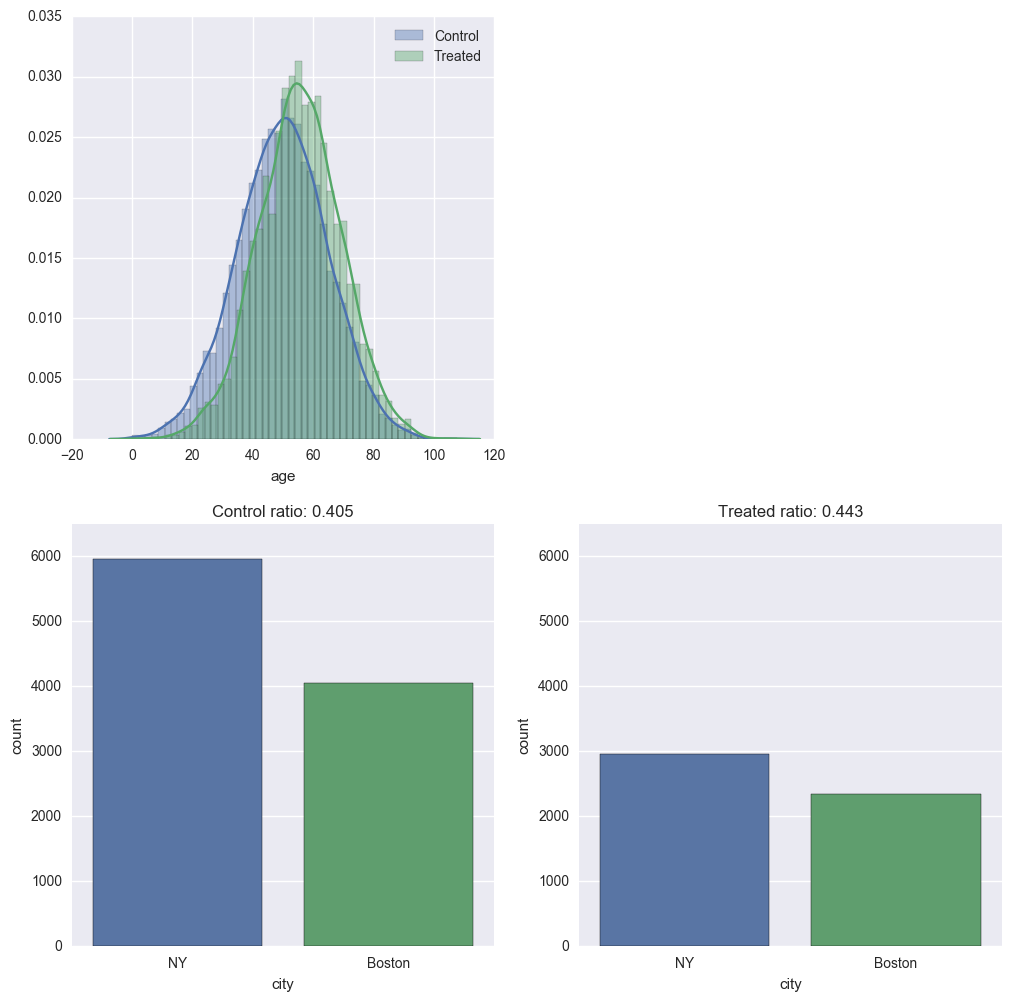

In [28]:
treated = demo_data[demo_data.treated]
compare_covariates_two(demo_data, treated, 'Control', 'Treated')

### What happens when we compare apples with apples

P-value for the KS-test on Age: 0.971948938003
Binomial test on Boston ratio: 0.813989098304


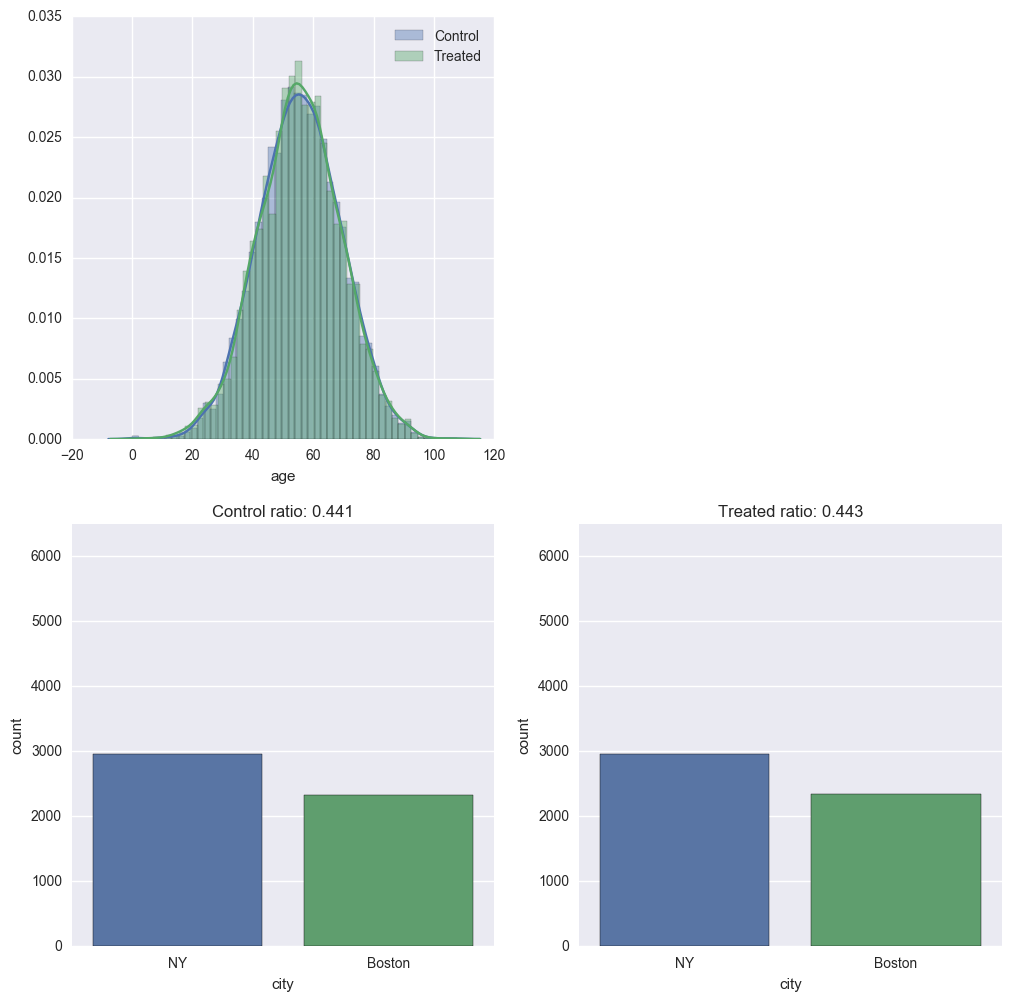

In [29]:
control = demo_data[demo_data.tod == 'morning']
compare_covariates_two(control, treated, 'Control', 'Treated')

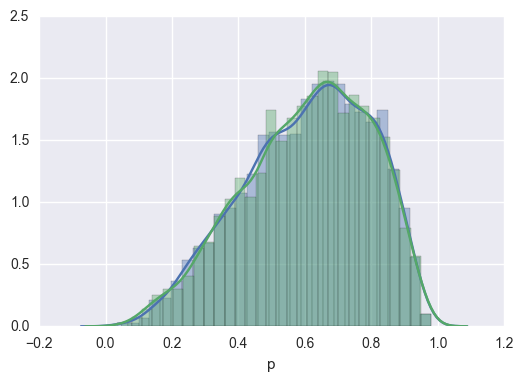

In [30]:
sns.distplot(control.p)
sns.distplot(treated.p)

In [31]:
print_comparison(control.y, treated.y_two)

Baseline: 0.411642411642
Other: 0.431054023423
P-val: 0.00218291051294


### It's actually the same... (which of course we knew given that we built the generating process behind it)

Note that when we generate the values for the treated group (`y_two`) we are a not actually changing anything.

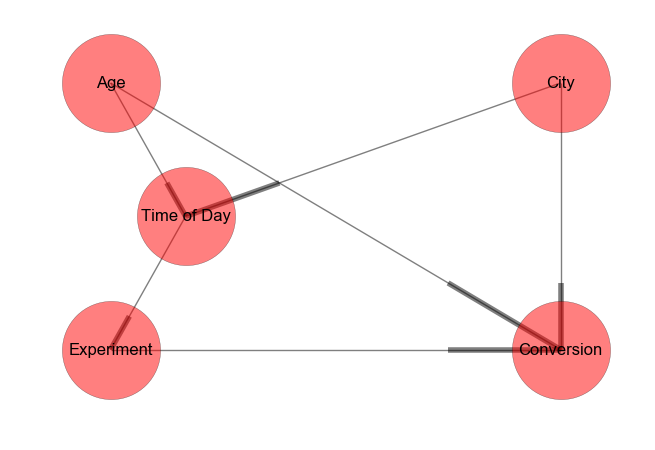

In [80]:
G = nx.DiGraph()
pos = nx.spring_layout(G)
labels = dict(zip(xrange(5), ['Age', 'City', 'Time of Day', 'Experiment', 'Conversion']))

graph.add_node(0, pos=(0, 4))
graph.add_node(1, pos=(3, 4))
graph.add_node(2, pos=(0.5, 2))
graph.add_node(3, pos=(0, 0))
graph.add_node(4, pos=(3, 0))

graph.add_edge(0, 2)
graph.add_edge(0, 4)
graph.add_edge(1, 2)
graph.add_edge(2, 3)
graph.add_edge(3, 4)

nx.draw(graph, nx.get_node_attributes(graph, 'pos'), labels=labels, with_labels=True, node_size=5000, alpha=0.5)

#### Graphs in networkx are ugly :(